# Probablistic model building genetic algorithm

In [1]:
%cd ..

/mnt/ceph/users/zzhang/CRISPR_pred/crispr_kinn


In [2]:
from silence_tensorflow import silence_tensorflow
silence_tensorflow()
from src.kinetic_model import KineticModel, modelSpace_to_modelParams, modelParams_to_modelSpace
from src.neural_network_builder import KineticEigenModelBuilder, KineticNeuralNetworkBuilder
from src.model_spaces import get_sim_model_space as get_model_space
from src.neural_search import search_env, get_reward_pipeline
#from src.data import get_sim_deplete_data as get_data
from src.runAmber_simkinn import get_data
from src.reload import reload_from_dir

Using TensorFlow backend.


0.1.2-pmbga


In [3]:
import warnings
warnings.filterwarnings('ignore')
import time
from datetime import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import yaml

import scipy.stats as ss
import pandas as pd
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import shutil
import os
import pickle
import gc
from sklearn.model_selection import train_test_split

## Load data

In [4]:
data_fp = "data/sim_data/22-06-28_synth_data_depl/test_1_depl.tsv"
param_fp = "data/sim_data/22-06-28_synth_data_depl/params.yaml"
logbase = 10
(x_train, y_train), (x_test, y_test) = get_data(fp=data_fp, logbase=logbase)

In [5]:
x_train.shape

(16000, 50, 4)

## Setup AMBER

In [6]:
import amber
print(amber.__version__)
from amber.architect import pmbga
from amber.architect import ModelSpace, Operation

0.1.2-pmbga


In [7]:
kinn_model_space = get_model_space(use_sink_state=False)
print(kinn_model_space)

StateSpace with 7 layers and 1 total combinations


In [8]:
controller = pmbga.ProbaModelBuildGeneticAlgo(
            model_space=kinn_model_space,
            buffer_type='population',
            buffer_size=125,   # buffer size controlls the max history going back
            batch_size=1,     # batch size does not matter in this case; all arcs will be retrieved
            ewa_beta=0.6,      # ewa_beta approximates the moving average over 1/(1-ewa_beta) prev points
        )

## A For-Loop that does the work for `amber.architect.trainEnv`

In [9]:
wd = "outputs/notebook_2"
# trainEnv parameters
evo_params = dict(
    model_fn = KineticNeuralNetworkBuilder,
    samps_per_gen = 2,   # how many arcs to sample in each generation; important
    max_gen = 750,
    patience = 300,
    n_warmup_gen = 0,
    train_data = (x_train, y_train),
    test_data = (x_test, y_test)
)

# manager configs
# this learning rate is trickier than usual, for eigendecomp to work
initial_learning_rate = 0.05
batch_size = 2000
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10*int(20000/batch_size), # decrease every 5 epochs
    decay_rate=0.9,
    staircase=True)

if logbase is None:
    output_op = lambda: tf.keras.layers.Lambda(lambda x: x, name="output_nominal")
else:
    output_op = lambda: tf.keras.layers.Lambda(lambda x: tf.math.log(x)/np.log(logbase), name="output_log")

manager_kwargs={
    'optimizer': lambda: tf.keras.optimizers.Adam(learning_rate=lr_schedule, clipnorm=1.),
    'output_op': output_op,
    'n_feats': 50,
    'n_channels': 4,
    'batch_size': batch_size,
    'epochs': 100,
    'earlystop': 5,
    'verbose': 0
}

In [10]:
controller, hist, stat_df = search_env(
    controller=controller, 
    wd = wd,
    evo_params=evo_params, 
    manager_kwargs=manager_kwargs
)

datapoints:  1 / total:  2
[02:16:48] Gen 0 - Mean fitness 0.573 - Best 0.6511 - PostVar 5.939 - Time 9.85
datapoints:  3 / total:  4
[02:16:56] Gen 1 - Mean fitness 0.585 - Best 0.6511 - PostVar 5.813 - Time 8.48
datapoints:  4 / total:  6
[02:17:02] Gen 2 - Mean fitness 0.581 - Best 0.6511 - PostVar 6.350 - Time 6.08
datapoints:  4 / total:  8
[02:17:12] Gen 3 - Mean fitness 0.621 - Best 0.6822 - PostVar 5.678 - Time 9.08
datapoints:  5 / total:  10
[02:17:20] Gen 4 - Mean fitness 0.643 - Best 0.6842 - PostVar 5.575 - Time 8.40
datapoints:  4 / total:  12
[02:17:28] Gen 5 - Mean fitness 0.666 - Best 0.7918 - PostVar 5.181 - Time 8.13
datapoints:  7 / total:  14
[02:17:38] Gen 6 - Mean fitness 0.631 - Best 0.7918 - PostVar 5.340 - Time 9.72
datapoints:  8 / total:  16
[02:17:48] Gen 7 - Mean fitness 0.610 - Best 0.7918 - PostVar 5.189 - Time 9.74
datapoints:  9 / total:  18
[02:17:57] Gen 8 - Mean fitness 0.629 - Best 0.7918 - PostVar 5.460 - Time 8.80
datapoints:  11 / total:  20
[02

datapoints:  29 / total:  152
[02:30:05] Gen 75 - Mean fitness 0.776 - Best 0.8476 - PostVar 4.674 - Time 11.50
datapoints:  24 / total:  154
[02:30:14] Gen 76 - Mean fitness 0.783 - Best 0.8476 - PostVar 5.304 - Time 8.69
datapoints:  30 / total:  156
[02:30:25] Gen 77 - Mean fitness 0.776 - Best 0.8476 - PostVar 5.035 - Time 11.66
datapoints:  29 / total:  158
[02:30:37] Gen 78 - Mean fitness 0.778 - Best 0.8476 - PostVar 4.743 - Time 11.57
datapoints:  20 / total:  160
[02:30:49] Gen 79 - Mean fitness 0.789 - Best 0.8476 - PostVar 4.799 - Time 11.83
datapoints:  39 / total:  162
[02:31:01] Gen 80 - Mean fitness 0.771 - Best 0.8476 - PostVar 4.662 - Time 12.15
datapoints:  50 / total:  164
[02:31:11] Gen 81 - Mean fitness 0.761 - Best 0.8476 - PostVar 5.111 - Time 10.04
datapoints:  43 / total:  166
[02:31:29] Gen 82 - Mean fitness 0.769 - Best 0.8476 - PostVar 4.899 - Time 17.22
datapoints:  45 / total:  168
[02:31:44] Gen 83 - Mean fitness 0.769 - Best 0.8476 - PostVar 4.749 - Time

datapoints:  118 / total:  250
[02:44:52] Gen 148 - Mean fitness 0.764 - Best 0.8834 - PostVar 4.947 - Time 11.54
datapoints:  135 / total:  250
[02:45:00] Gen 149 - Mean fitness 0.757 - Best 0.8834 - PostVar 4.760 - Time 8.46
datapoints:  122 / total:  250
[02:45:12] Gen 150 - Mean fitness 0.763 - Best 0.8834 - PostVar 5.068 - Time 11.85
datapoints:  110 / total:  250
[02:45:21] Gen 151 - Mean fitness 0.770 - Best 0.8834 - PostVar 4.666 - Time 9.17
datapoints:  119 / total:  250
[02:45:35] Gen 152 - Mean fitness 0.766 - Best 0.8834 - PostVar 4.314 - Time 13.66
datapoints:  102 / total:  250
[02:45:47] Gen 153 - Mean fitness 0.774 - Best 0.8834 - PostVar 4.724 - Time 11.26
datapoints:  121 / total:  250
[02:45:58] Gen 154 - Mean fitness 0.765 - Best 0.8834 - PostVar 4.507 - Time 11.34
datapoints:  129 / total:  250
[02:46:08] Gen 155 - Mean fitness 0.763 - Best 0.8834 - PostVar 4.640 - Time 9.97
datapoints:  140 / total:  250
[02:46:20] Gen 156 - Mean fitness 0.758 - Best 0.8834 - Post

datapoints:  80 / total:  250
[02:59:15] Gen 221 - Mean fitness 0.793 - Best 0.8834 - PostVar 4.864 - Time 13.06
datapoints:  55 / total:  250
[02:59:28] Gen 222 - Mean fitness 0.805 - Best 0.8834 - PostVar 4.611 - Time 12.78
datapoints:  98 / total:  250
[02:59:37] Gen 223 - Mean fitness 0.783 - Best 0.8834 - PostVar 4.632 - Time 9.04
datapoints:  99 / total:  250
[02:59:47] Gen 224 - Mean fitness 0.782 - Best 0.8834 - PostVar 4.494 - Time 9.65
datapoints:  93 / total:  250
[03:00:00] Gen 225 - Mean fitness 0.786 - Best 0.8834 - PostVar 4.786 - Time 13.22
datapoints:  75 / total:  250
[03:00:12] Gen 226 - Mean fitness 0.795 - Best 0.8834 - PostVar 4.513 - Time 11.85
datapoints:  94 / total:  250
[03:00:24] Gen 227 - Mean fitness 0.786 - Best 0.8834 - PostVar 4.513 - Time 11.42
datapoints:  121 / total:  250
[03:00:35] Gen 228 - Mean fitness 0.774 - Best 0.8834 - PostVar 4.504 - Time 11.21
datapoints:  122 / total:  250
[03:00:52] Gen 229 - Mean fitness 0.775 - Best 0.8834 - PostVar 4.

datapoints:  140 / total:  250
[03:13:58] Gen 294 - Mean fitness 0.772 - Best 0.8834 - PostVar 4.551 - Time 10.30
datapoints:  108 / total:  250
[03:14:12] Gen 295 - Mean fitness 0.789 - Best 0.8834 - PostVar 4.332 - Time 14.09
datapoints:  95 / total:  250
[03:14:21] Gen 296 - Mean fitness 0.794 - Best 0.8834 - PostVar 4.839 - Time 8.90
datapoints:  112 / total:  250
[03:14:32] Gen 297 - Mean fitness 0.788 - Best 0.8834 - PostVar 4.464 - Time 10.69
datapoints:  117 / total:  250
[03:14:40] Gen 298 - Mean fitness 0.785 - Best 0.8834 - PostVar 4.310 - Time 8.41
datapoints:  82 / total:  250
[03:14:50] Gen 299 - Mean fitness 0.798 - Best 0.8834 - PostVar 4.084 - Time 9.51
datapoints:  109 / total:  250
[03:15:01] Gen 300 - Mean fitness 0.789 - Best 0.8834 - PostVar 4.052 - Time 11.63
datapoints:  141 / total:  250
[03:15:13] Gen 301 - Mean fitness 0.773 - Best 0.8834 - PostVar 4.530 - Time 11.30
datapoints:  167 / total:  250
[03:15:23] Gen 302 - Mean fitness 0.764 - Best 0.8834 - PostVa

datapoints:  151 / total:  250
[03:28:35] Gen 367 - Mean fitness 0.775 - Best 0.8842 - PostVar 4.408 - Time 10.81
datapoints:  138 / total:  250
[03:28:45] Gen 368 - Mean fitness 0.783 - Best 0.8842 - PostVar 4.358 - Time 10.07
datapoints:  138 / total:  250
[03:28:57] Gen 369 - Mean fitness 0.785 - Best 0.8842 - PostVar 4.248 - Time 10.99
datapoints:  99 / total:  250
[03:29:09] Gen 370 - Mean fitness 0.801 - Best 0.8842 - PostVar 4.141 - Time 12.66
datapoints:  78 / total:  250
[03:29:20] Gen 371 - Mean fitness 0.811 - Best 0.8842 - PostVar 4.245 - Time 11.15
datapoints:  79 / total:  250
[03:29:35] Gen 372 - Mean fitness 0.811 - Best 0.8842 - PostVar 4.425 - Time 14.41
datapoints:  86 / total:  250
[03:29:46] Gen 373 - Mean fitness 0.807 - Best 0.8842 - PostVar 4.480 - Time 10.54
datapoints:  110 / total:  250
[03:29:56] Gen 374 - Mean fitness 0.797 - Best 0.8842 - PostVar 4.559 - Time 10.66
datapoints:  149 / total:  250
[03:30:05] Gen 375 - Mean fitness 0.776 - Best 0.8842 - PostV

datapoints:  67 / total:  250
[03:43:40] Gen 440 - Mean fitness 0.822 - Best 0.9387 - PostVar 4.536 - Time 15.49
datapoints:  79 / total:  250
[03:43:52] Gen 441 - Mean fitness 0.817 - Best 0.9387 - PostVar 3.769 - Time 11.64
datapoints:  147 / total:  250
[03:44:02] Gen 442 - Mean fitness 0.791 - Best 0.9387 - PostVar 4.453 - Time 10.38
datapoints:  109 / total:  250
[03:44:14] Gen 443 - Mean fitness 0.805 - Best 0.9387 - PostVar 3.997 - Time 12.26
datapoints:  93 / total:  250
[03:44:26] Gen 444 - Mean fitness 0.811 - Best 0.9387 - PostVar 4.275 - Time 11.31
datapoints:  55 / total:  250
[03:44:40] Gen 445 - Mean fitness 0.833 - Best 0.9387 - PostVar 4.260 - Time 14.53
datapoints:  105 / total:  250
[03:44:52] Gen 446 - Mean fitness 0.807 - Best 0.9387 - PostVar 3.987 - Time 11.72
datapoints:  134 / total:  250
[03:45:01] Gen 447 - Mean fitness 0.798 - Best 0.9387 - PostVar 4.235 - Time 8.43
datapoints:  173 / total:  250
[03:45:10] Gen 448 - Mean fitness 0.778 - Best 0.9387 - PostVa

datapoints:  114 / total:  250
[03:58:55] Gen 513 - Mean fitness 0.819 - Best 0.9387 - PostVar 3.624 - Time 9.67
datapoints:  114 / total:  250
[03:59:09] Gen 514 - Mean fitness 0.821 - Best 0.9387 - PostVar 4.011 - Time 13.33
datapoints:  103 / total:  250
[03:59:20] Gen 515 - Mean fitness 0.826 - Best 0.9387 - PostVar 4.049 - Time 11.27
datapoints:  48 / total:  250
[03:59:40] Gen 516 - Mean fitness 0.851 - Best 0.9429 - PostVar 4.438 - Time 19.60
datapoints:  60 / total:  250
[03:59:55] Gen 517 - Mean fitness 0.843 - Best 0.9429 - PostVar 3.885 - Time 14.87
datapoints:  85 / total:  250
[04:00:08] Gen 518 - Mean fitness 0.833 - Best 0.9429 - PostVar 4.120 - Time 12.68
datapoints:  76 / total:  250
[04:00:21] Gen 519 - Mean fitness 0.838 - Best 0.9429 - PostVar 4.268 - Time 13.56
datapoints:  102 / total:  250
[04:00:31] Gen 520 - Mean fitness 0.828 - Best 0.9429 - PostVar 3.848 - Time 9.94
datapoints:  122 / total:  250
[04:00:42] Gen 521 - Mean fitness 0.816 - Best 0.9429 - PostVar

datapoints:  142 / total:  250
[04:15:33] Gen 586 - Mean fitness 0.819 - Best 0.9429 - PostVar 3.757 - Time 19.11
datapoints:  105 / total:  250
[04:15:49] Gen 587 - Mean fitness 0.837 - Best 0.9429 - PostVar 4.133 - Time 16.06
datapoints:  136 / total:  250
[04:15:58] Gen 588 - Mean fitness 0.822 - Best 0.9429 - PostVar 3.909 - Time 8.98
datapoints:  125 / total:  250
[04:16:12] Gen 589 - Mean fitness 0.828 - Best 0.9429 - PostVar 3.653 - Time 13.92
datapoints:  92 / total:  250
[04:16:26] Gen 590 - Mean fitness 0.840 - Best 0.9429 - PostVar 3.868 - Time 13.71
datapoints:  64 / total:  250
[04:16:44] Gen 591 - Mean fitness 0.851 - Best 0.9429 - PostVar 3.775 - Time 18.14
datapoints:  42 / total:  250
[04:16:57] Gen 592 - Mean fitness 0.860 - Best 0.9429 - PostVar 3.954 - Time 12.68
datapoints:  82 / total:  250
[04:17:11] Gen 593 - Mean fitness 0.843 - Best 0.9429 - PostVar 3.860 - Time 13.87
datapoints:  135 / total:  250
[04:17:25] Gen 594 - Mean fitness 0.826 - Best 0.9429 - PostVa

datapoints:  173 / total:  250
[04:32:38] Gen 659 - Mean fitness 0.811 - Best 0.9429 - PostVar 3.856 - Time 11.92
datapoints:  130 / total:  250
[04:32:53] Gen 660 - Mean fitness 0.833 - Best 0.9429 - PostVar 3.686 - Time 15.08
datapoints:  133 / total:  250
[04:33:10] Gen 661 - Mean fitness 0.831 - Best 0.9429 - PostVar 4.042 - Time 16.63
datapoints:  130 / total:  250
[04:33:20] Gen 662 - Mean fitness 0.833 - Best 0.9429 - PostVar 3.991 - Time 9.79
datapoints:  102 / total:  250
[04:33:32] Gen 663 - Mean fitness 0.842 - Best 0.9429 - PostVar 4.004 - Time 12.25
datapoints:  86 / total:  250
[04:33:47] Gen 664 - Mean fitness 0.849 - Best 0.9429 - PostVar 4.255 - Time 14.70
datapoints:  77 / total:  250
[04:34:07] Gen 665 - Mean fitness 0.854 - Best 0.9429 - PostVar 3.843 - Time 20.15
datapoints:  88 / total:  250
[04:34:22] Gen 666 - Mean fitness 0.848 - Best 0.9429 - PostVar 3.938 - Time 14.69
datapoints:  85 / total:  250
[04:34:38] Gen 667 - Mean fitness 0.848 - Best 0.9429 - PostVa

datapoints:  208 / total:  250
[04:50:04] Gen 732 - Mean fitness 0.791 - Best 0.9429 - PostVar 3.785 - Time 11.63
datapoints:  149 / total:  250
[04:50:14] Gen 733 - Mean fitness 0.824 - Best 0.9429 - PostVar 3.560 - Time 10.51
datapoints:  97 / total:  250
[04:50:30] Gen 734 - Mean fitness 0.849 - Best 0.9429 - PostVar 3.896 - Time 15.80
datapoints:  106 / total:  250
[04:50:46] Gen 735 - Mean fitness 0.844 - Best 0.9429 - PostVar 3.885 - Time 15.48
datapoints:  137 / total:  250
[04:50:55] Gen 736 - Mean fitness 0.832 - Best 0.9429 - PostVar 3.612 - Time 8.97
datapoints:  131 / total:  250
[04:51:04] Gen 737 - Mean fitness 0.834 - Best 0.9429 - PostVar 3.595 - Time 9.26
datapoints:  92 / total:  250
[04:51:20] Gen 738 - Mean fitness 0.852 - Best 0.9429 - PostVar 3.809 - Time 15.50
datapoints:  105 / total:  250
[04:51:32] Gen 739 - Mean fitness 0.843 - Best 0.9429 - PostVar 3.842 - Time 11.75
datapoints:  106 / total:  250
[04:51:48] Gen 740 - Mean fitness 0.843 - Best 0.9429 - PostV

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman


In [11]:
pd.DataFrame(hist).sort_values('test_reward', ascending=False).head()

,gen,arc,test_reward,rate_df
1032,516,"[conv1d:{'kernel_size': 1, 'filters': 1, 'SOUR...",0.942934,None
881,440,"[conv1d:{'kernel_size': 1, 'filters': 1, 'SOUR...",0.938724,None
1239,619,"[conv1d:{'kernel_size': 1, 'filters': 1, 'SOUR...",0.934716,None
1438,719,"[conv1d:{'kernel_size': 1, 'filters': 1, 'SOUR...",0.930050,None
769,384,"[conv1d:{'kernel_size': 1, 'filters': 1, 'SOUR...",0.922920,None


In [12]:
print("\n".join([str(x) 
                 for x in pd.DataFrame(hist).
                 sort_values('test_reward', ascending=False).
                 head(1)['arc'].values[0]]))

conv1d:{'kernel_size': 1, 'filters': 1, 'SOURCE': '0', 'TARGET': '1', 'EDGE': 1, 'RANGE_ST': 5, 'RANGE_D': 5}
conv1d:{'kernel_size': 1, 'filters': 1, 'SOURCE': '1', 'TARGET': '0', 'EDGE': 1, 'RANGE_ST': 10, 'RANGE_D': 14}
conv1d:{'kernel_size': 1, 'filters': 1, 'SOURCE': '1', 'TARGET': '2', 'EDGE': 1, 'RANGE_ST': 15, 'RANGE_D': 10}
conv1d:{'kernel_size': 1, 'filters': 1, 'SOURCE': '2', 'TARGET': '1', 'EDGE': 1, 'RANGE_ST': 20, 'RANGE_D': 5}
conv1d:{'kernel_size': 1, 'filters': 1, 'SOURCE': '2', 'TARGET': '3', 'EDGE': 1, 'RANGE_ST': 25, 'RANGE_D': 4}
conv1d:{'kernel_size': 1, 'filters': 1, 'SOURCE': '3', 'TARGET': '2', 'EDGE': 1, 'RANGE_ST': 30, 'RANGE_D': 9}
conv1d:{'kernel_size': 1, 'filters': 1, 'SOURCE': '3', 'TARGET': '0', 'EDGE': 1, 'RANGE_ST': 35, 'RANGE_D': 5, 'CONTRIB': 1}


In [13]:
a = pd.DataFrame(hist)
a['arc'] = ['|'.join([f"{x.Layer_attributes['RANGE_ST']}-{x.Layer_attributes['RANGE_ST']+x.Layer_attributes['RANGE_D']}" for x in entry]) for entry in a['arc']]
a.drop(columns=['rate_df'], inplace=True)
a.to_csv(os.path.join(wd,"train_history.tsv"), sep="\t", index=False)

Text(0.5, 0, 'Generation')

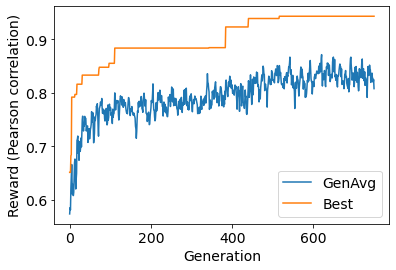

In [14]:
%matplotlib inline

ax = stat_df.plot.line(x='Generation', y=['GenAvg', 'Best'])
ax.set_ylabel("Reward (Pearson correlation)")
ax.set_xlabel("Generation")
#plt.savefig("reward_vs_time.png")

In [15]:
# ground truth
plot_gt = True
with open(param_fp, "r") as f:
    gt_model_params = yaml.load(f, Loader=yaml.Loader)
gt_model_params = modelParams_to_modelSpace(gt_model_params)
gt_rates = [k for k in gt_model_params['Rates']]

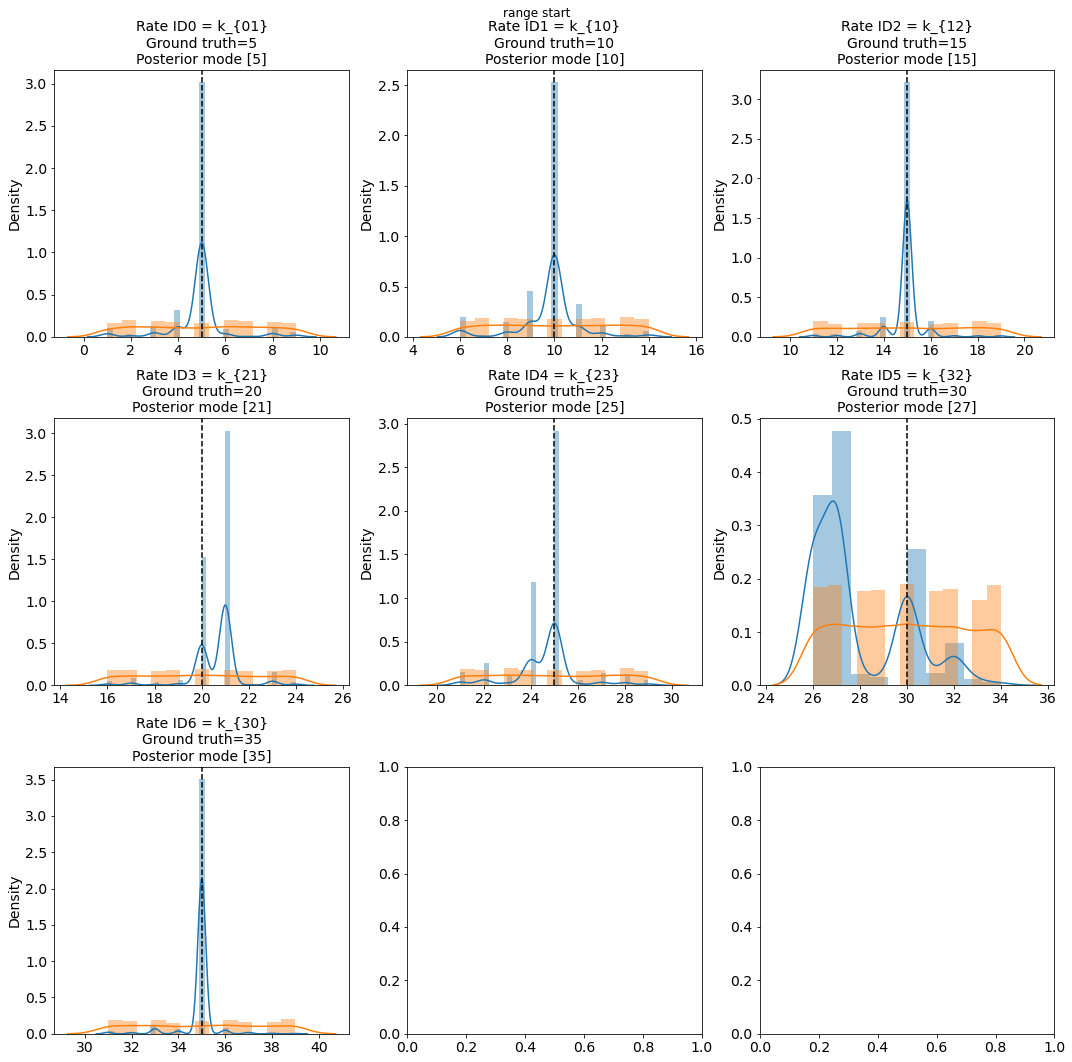

In [16]:
# START SITE
fig, axs_ = plt.subplots(3,3, figsize=(15,15))
axs = [axs_[i][j] for i in range(len(axs_)) for j in range(len(axs_[i]))]
for k in controller.model_space_probs:
    if k[-1] == 'RANGE_ST':
        try:
            d = controller.model_space_probs[k].sample(size=1000)
        except:
            continue
        ax = axs[k[0]]
        sns.distplot(d, label="Post", ax=ax)
        sns.distplot(controller.model_space_probs[k].prior_dist, label="Prior", ax=ax)
        if plot_gt:
            ax.axvline(gt_rates[k[0]]['RANGE_ST'], ls='--', color='black')
            ax.set_title(
                f'Rate ID{str(k[0])} = {gt_rates[k[0]]["name"]}\n'
                f'Ground truth={gt_rates[k[0]]["RANGE_ST"]}\nPosterior mode {str(ss.mode(d).mode)}')
        else:
            ax.set_title(
                f'Rate ID{str(k[0])} = {gt_rates[k[0]]["name"]}\n'
                f'Posterior mode {str(ss.mode(d).mode)}')
            

        #_ = ax.set_xlim(0,50)

fig.suptitle('range start')
fig.tight_layout()
#fig.savefig("range_st.png")

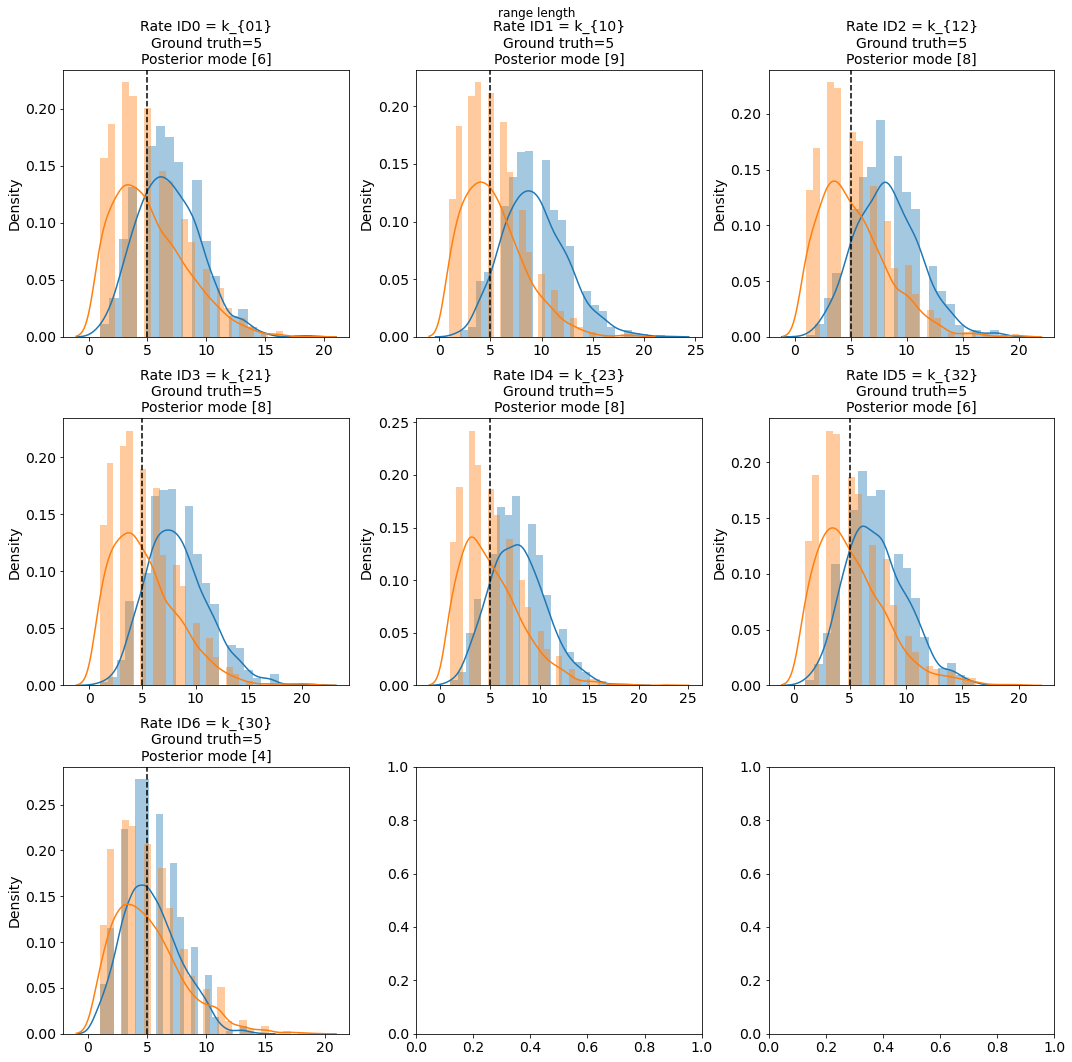

In [17]:
# CONV RANGE
fig, axs_ = plt.subplots(3,3, figsize=(15,15))
axs = [axs_[i][j] for i in range(len(axs_)) for j in range(len(axs_[i]))]
for k in controller.model_space_probs:
    if k[-1] == 'RANGE_D':
        d = controller.model_space_probs[k].sample(size=1000)
        ax = axs[k[0]]
        sns.distplot(d, ax=ax)
        sns.distplot(controller.model_space_probs[k].prior_dist, label="Prior", ax=ax)
        if plot_gt:
            ax.axvline(gt_rates[k[0]]['RANGE_D'], ls='--', color='black')
            ax.set_title(
                f'Rate ID{str(k[0])} = {gt_rates[k[0]]["name"]}\n'
                f'Ground truth={gt_rates[k[0]]["RANGE_D"]}\nPosterior mode {str(ss.mode(d).mode)}')
        else:
            ax.set_title(
                f'Rate ID{str(k[0])} = {gt_rates[k[0]]["name"]}\n'
                f'Posterior mode {str(ss.mode(d).mode)}')

fig.suptitle('range length')
fig.tight_layout()
#fig.savefig("range_d.png")

In [18]:
from src.neural_network_builder import KineticEigenModelBuilder, KineticNeuralNetworkBuilder
tf.compat.v1.reset_default_graph()
tf.compat.v1.experimental.output_all_intermediates(True)
sess = tf.compat.v1.Session()
mb = reload_from_dir(
    wd=wd, 
    manager_kwargs=manager_kwargs,
    sess=sess,
    model_fn=KineticNeuralNetworkBuilder)
model = mb.model

loaded searched model


In [19]:
[str(x.__dict__) for x in mb.kinn.rates]

["{'name': 'k_01', 'state_list': ['0', '1'], 'input_range': [5, 10], 'kernel_size': 1, 'scatter_nd': [((0, 0), -1), ((1, 0), 1)], 'filters': 1, 'SOURCE': '0', 'TARGET': '1', 'EDGE': 1, 'RANGE_ST': 5, 'RANGE_D': 5, 'template': None, 'mat': None}",
 "{'name': 'k_10', 'state_list': ['1', '0'], 'input_range': [10, 24], 'kernel_size': 1, 'scatter_nd': [((1, 1), -1), ((0, 1), 1)], 'filters': 1, 'SOURCE': '1', 'TARGET': '0', 'EDGE': 1, 'RANGE_ST': 10, 'RANGE_D': 14, 'template': None, 'mat': None}",
 "{'name': 'k_12', 'state_list': ['1', '2'], 'input_range': [15, 25], 'kernel_size': 1, 'scatter_nd': [((1, 1), -1), ((2, 1), 1)], 'filters': 1, 'SOURCE': '1', 'TARGET': '2', 'EDGE': 1, 'RANGE_ST': 15, 'RANGE_D': 10, 'template': None, 'mat': None}",
 "{'name': 'k_21', 'state_list': ['2', '1'], 'input_range': [20, 25], 'kernel_size': 1, 'scatter_nd': [((2, 2), -1), ((1, 2), 1)], 'filters': 1, 'SOURCE': '2', 'TARGET': '1', 'EDGE': 1, 'RANGE_ST': 20, 'RANGE_D': 5, 'template': None, 'mat': None}",
 "{'

In [20]:
layer_dict = {l.name:l for l in model.layers}

In [21]:
np.around(layer_dict['conv_k0'].get_weights()[0],3)

array([[[-1.183],
        [-0.427],
        [-0.266],
        [ 0.386]]], dtype=float32)

In [22]:
np.around(layer_dict['conv_k1'].get_weights()[0],3)

array([[[-0.069],
        [-0.172],
        [-0.655],
        [ 0.523]]], dtype=float32)

spearman SpearmanrResult(correlation=0.932868488747965, pvalue=0.0)
pearson (0.9429342383098863, 0.0)


Text(0.5, 0.98, 'Testing prediction, pcc=0.943')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman


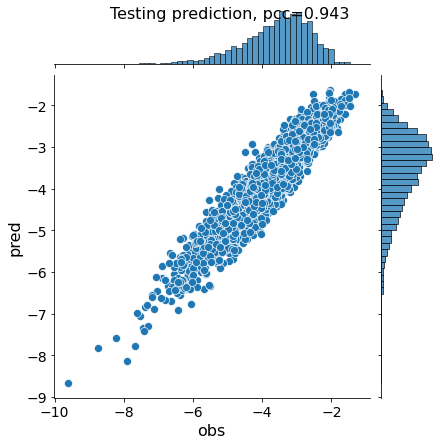

In [23]:
x_test_b = mb.blockify_seq_ohe(x_test)
y_hat = model.predict(x_test_b).flatten()
h = sns.jointplot(y_test, y_hat)
h.set_axis_labels("obs", "pred", fontsize=16)
print("spearman", ss.spearmanr(y_hat, y_test))
p = ss.pearsonr(y_hat, y_test)
print("pearson", p)
h.fig.suptitle("Testing prediction, pcc=%.3f"%p[0], fontsize=16)

In [24]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Mon Sep 05 2022

Python implementation: CPython
Python version       : 3.7.9
IPython version      : 7.22.0

tensorflow: 1.15.0
numpy     : 1.21.6
yaml      : 5.4.1
scipy     : 1.7.3
seaborn   : 0.11.1
matplotlib: 3.4.3
amber     : 0.1.2-pmbga
pandas    : 1.3.5

Watermark: 2.3.1

